# RNN USE
I denne notebooken tar jeg i bruk den modellen jeg har lagd tidligere

In [1]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens

In [2]:
def create_dataset(dataset, true_price, look_back = 1, look_forward = 1):
    
    # Standarised
    sc = preprocessing.StandardScaler()
    dataset = sc.fit_transform(dataset)

    lookback = look_back
    trueprice = []
    datax = []
    datay = []

    for i,v in enumerate(dataset):
        if i > lookback + look_forward:
            datax.append([dataset[i-j] for j in range(lookback+look_forward, look_forward, -1)])
            datay.append([true_price[i-j] for j in range(look_forward, 0, -1)])   
    
    trueprice = [i for i in true_price]
    datax = np.array(datax)
    datay = np.array(datay)
    trueprice = np.array(trueprice)
    
    # Standardize y data for å skille dem fra hverandre
    mean = [1 for _ in range(datay.shape[1])]
    std = [0.0006 for _ in range(datay.shape[1])]
    datay -= mean
    trueprice -= mean[0]
    
    datay /= std
    trueprice /= std[0]
    
    return datax, datay, trueprice

In [167]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_15_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma15_derivert'] = [stock.open_15_sma[i] / stock.open_15_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_15_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        stocks.append(stock)
    
    return stocks


def evaluate_trade(data, prediction, look_forward):
    
    # Setter indeks til hver for å få riktig.. Litt tungvindt
    where_are_NaNs = np.isnan(prediction) #Byttet NaN til 1
    prediction[where_are_NaNs] = 1
    
    dict_pred = {}
    
    for i, pred in enumerate(prediction):
        for j, v in enumerate(pred):
            if i+j not in dict_pred:
                dict_pred[i+j] = [v]
            else:
                dict_pred[i+j].append(v)
    
    
    df_pred = pd.DataFrame(columns=['tid','verdier','avg'])
    df_pred.tid = list(dict_pred.keys())
    df_pred.verdier = list(dict_pred.values())
    df_pred.avg = [sum(l)/len(l) for l in list(dict_pred.values())]
    
    return df_pred       
    df_pred = pd.DataFrame.from_dict(dict_pred, orient='index')
    p_df = []
    for i, row in df_pred.iterrows():
        temp = [j for j in row]
        p_df.append(temp)
        
    df_pred = pd.DataFrame(p_df)
    
    # Finner riktig basert på indeks
    #for i, pred in enumerate(my_pred):
    #    all_pred[i].append()
    
    
        #o+=1
        #prediction[i][j] = i+1
        
        #for j in look_forward:
        #    prediction[i+j]
    #my_pred
    return df_pred
    
    
    all_pred = [[] for _ in range(prediction.shape[0])]
    
    
    for i,pred in enumerate(prediction):
        
        
        o=0
        print(pred)
        for _ in range(len(pred)):
            
            if i+o < prediction.shape[0]:
                all_pred[i].append(prediction[i+o][o])
            o += 1
            
    avg_pred = []
    #print((all_pred))
    for pred in all_pred:
        avg_pred.append(sum(pred)/len(pred))

    #print(len(prediction), len(avg_pred))
    fig, ax1 = plt.subplots()
    
    for i,v in enumerate(prediction):
        ax1.plot(range(i+30, i+look_forward+len(v)), v, color='red')
    ax1.plot(range(30,look_forward + len(avg_pred)), avg_pred, color="black")
    
    ax2 = ax1.twinx()
    
    ax2.plot(data.open, color='blue')
    
    

    
def add_data(word):
    ordet = 'data/' + word
    return ordet


In [5]:
filer = list(map(add_data, os.listdir('data/')))[21:22] # test 54:60
data = make_ready(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [10]:
dataxes = []
datayes = []
sanne = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay, sann = create_dataset(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.append(datax)
    datayes.append(datay)
    sanne.append(sann)

In [6]:
model = keras.models.load_model('models/rnn_model.h5')

In [168]:
evaluate_trade(data[0], model.predict(dataxes[0]), look_forward)

,tid,verdier,avg
0,0,[1.0],1.000000
1,1,"[1.0, 1.067708]",1.033854
2,2,"[1.0, 1.0544925, 1.1224247]",1.058972
3,3,"[1.0, 1.0793521, 1.099982, 1.1459711]",1.081326
4,4,"[1.0, 1.0539215, 1.11831, 1.1149298, 1.1781483]",1.093062
...,...,...,...
399,399,"[0.4970053, 0.50822765, 0.41537395, 0.46198332...",0.469135
400,400,"[0.45701042, 0.48310855, 0.41321597, 0.4683086]",0.455411
401,401,"[0.41351396, 0.4717585, 0.4082696]",0.431181
402,402,"[0.3898506, 0.45867342]",0.424262


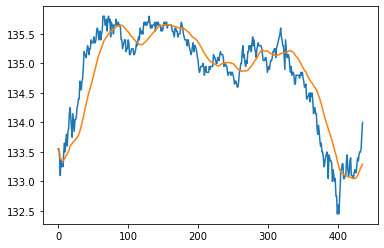

In [69]:
plt.plot(data[0].open)
plt.plot(data[0].open_30_sma)

In [143]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,133.55,133.55,133.55,133.55,77319,77319,NaN,NaN,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
1,9:1,133.55,133.55,133.55,133.55,13845,13845,133.55,0.00,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
2,9:2,133.40,133.40,133.40,133.40,29772,29772,133.55,-0.15,0.000000,...,133.500000,-0.004651,-0.001906,-0.002745,133.500000,133.500000,0.000000,0.999626,0.999626,0.998877
3,9:3,133.10,133.10,133.10,133.10,14807,14807,133.40,-0.30,0.000000,...,133.400000,-0.017484,-0.007183,-0.010301,133.400000,133.400000,0.000000,0.999251,0.999251,0.997751
4,9:4,133.35,133.35,133.35,133.35,13958,13958,133.10,0.25,0.594707,...,133.390000,-0.014142,-0.009253,-0.004888,133.390000,133.390000,0.000000,0.999925,0.999925,1.001878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,16:16,133.50,133.50,133.50,133.50,12738,12738,133.45,0.05,1.274000,...,133.243750,0.060187,0.021415,0.038772,133.195000,133.250000,0.068750,1.000263,1.000175,1.000375
432,16:17,133.50,133.50,133.50,133.50,33641,33641,133.50,0.00,1.274000,...,133.265625,0.071448,0.031421,0.040027,133.223333,133.260000,0.084375,1.000213,1.000075,1.000000
433,16:18,133.55,133.55,133.55,133.55,12709,12709,133.50,0.05,1.336942,...,133.278125,0.083446,0.041826,0.041619,133.245000,133.270000,0.121875,1.000163,1.000075,1.000375
434,16:19,133.80,133.80,133.80,133.80,17495,17495,133.55,0.25,1.668213,...,133.303125,0.111837,0.055828,0.056009,133.265000,133.316667,0.178125,1.000150,1.000350,1.001872
